# Self-Improving RAG Agent

## 1. Introduction

Traditional RAG systems have a critical limitation: they retrieve documents once and then generate an answer based on those documents, regardless of their relevance. An agentic approach allows the system to adapt its retrieval strategy. This static approach often fails when:

- The initial query is ambiguous or poorly formulated
- The retrieval system returns irrelevant documents
- The information needed is spread across multiple documents

By the end of this notebook, you'll have a reproducible methodology for evaluating RAG Agents systematically.

## 2. Setup

First, let's install the necessary libraries and set up our environment:

In [ ]:

# Install required packages
%pip install openai chromadb sentence_transformers pandas matplotlib numpy tqdm

In [46]:
# Install required packages
import openai
import chromadb
from chromadb.utils import embedding_functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import getpass
from tqdm import tqdm
from sentence_transformers import CrossEncoder
from typing import Optional, List, Dict, Type, Any

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 100)

# Define paths
DATA_DIR = "../data/papers"
EVAL_DIR = "../data/evalset"

# Initialize OpenAI and Chroma
openai.api_key = getpass.getpass('Enter your OpenAI API key: ')
chroma_client = chromadb.PersistentClient()

# Global variables
K_VALUES = [1, 3, 5, 10]

## 3.Loading Evaluation Dataset

We'll use the evaluation dataset we created in the previous notebook to test our RAG Agent.

In [45]:
eval_df = pd.read_json('../data/evalset/evalset.json')
print(f"Loaded {len(eval_df)} evaluation examples")

Loaded 214 evaluation examples


## 4. Build the RAG Agent

Before we implement our agent, let's understand the key components of an agentic RAG system:

- Retriever: Fetches relevant documents based on a query
- Evaluator: Assesses the quality of retrieved documents
- Query Reformulator: Rewrites queries to improve retrieval
- Decision Maker: Determines when to stop iterating
- Answer Generator: Creates the final response

We'll be focusing specifically on the retrieval component of the RAG Agent. This is because the retrieval component is the most critical part of the Agent and the one that is most likely to fail. If you can't retrieve the right documents, you can't generate a good answer. We'll create a flexible agent class that can be configured with different embedding models and rerankers and retrieval strategies. Let's go. 

In [52]:
class RAGAgent:
    def __init__(self, collection, llm_model: str = "gpt-3.5-turbo", embedding_model: str = "text-embedding-3-small", reranker_model: Optional[str] = None):
        self.collection = collection
        self.llm_model = llm_model
        self.embedding_model = embedding_model
        self.reranker_model = reranker_model
        self.max_iterations = 3
        self.target_metrics = {"recall": 0.8, "mrr": 0.5}
        self.top_k = 10
        self.agent_type = self.__class__.__name__

    # Retrieve relevant documents
    def retrieve(self, query: str):
        results = self.collection.query(query_texts=[query], n_results=self.top_k)
        results = {"ids": results['ids'][0], "documents": results['documents'][0]}
        
        if self.reranker_model:
            cross_encoder = CrossEncoder(self.reranker_model)
            pairs = [(query, doc) for doc in results["documents"]]
            scores = cross_encoder.predict(pairs)
            reranked_indices = np.argsort(-scores)[:self.top_k]
            return {
                "ids": [results["ids"][i] for i in reranked_indices],
                "documents": [results["documents"][i] for i in reranked_indices]
            }

        return results
    
    # Evaluate retrieval quality
    def evaluate_retrieval(self, predictions: List[str], ground_truth: List[str]):
        metrics = {}

        def calculate_mrr(predictions: list[str], ground_truth: list[str]):
            mrr = 0
            for label in ground_truth:
                if label in predictions:
                    mrr = max(mrr, 1 / (predictions.index(label) + 1))
            return mrr
        
        def calculate_recall(predictions: list[str], ground_truth: list[str]):
            return len([label for label in ground_truth if label in predictions]) / len(ground_truth)
        
        for k in K_VALUES:
            metrics[f"mrr@{k}"] = calculate_mrr(predictions[:k], ground_truth)
            metrics[f"recall@{k}"] = calculate_recall(predictions[:k], ground_truth)

        return metrics
    
    # Rewrite query to improve retrieval
    def rewrite_query(self, query: str, retrieved_docs: List[str]):
        system_prompt = "You are an assistant that refines search queries to be precise and targeted for optimal document retrieval."
        user_message = f"Original query: {query}\n\n"
    
        if retrieved_docs:
            user_message += f"The following documents were retrieved but did not achieve good retrieval metrics:\n\n"
            for i, doc in enumerate(retrieved_docs[:3]):
                user_message += f"Document {i+1}:\n{doc}\n\n"
        user_message += f"Please rewrite the query to be more specific and targeted to improve retrieval performance. Return ONLY the reformulated query without any explanations or additional text."
    
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ]
        )
    
        return response.choices[0].message.content.strip()    

    # Generate final answer
    def generate_answer(self, query: str, documents: List[str]):
        context = "\n\n".join(documents)
        response = openai.chat.completions.create(
            model=self.llm_model,
            messages=[
                {"role": "system", "content": "You are an assistant that answers questions based on the provided context."},
                {"role": "user", "content": f"Context:\n{context}\n\nQuestion: {query}\n\nAnswer the question based on the context provided. If the context doesn't contain the answer, say 'I don't have enough information to answer this question.'"}
            ]
        )
        return response.choices[0].message.content
    
    # Check if target metrics are met
    def _is_target_achieved(self, metrics: Dict[str, float]) -> bool:
        recall_key = f"recall@{self.top_k}"
        mrr_key = f"mrr@{self.top_k}"
        
        current_recall = metrics.get(recall_key, 0)
        current_mrr = metrics.get(mrr_key, 0)
        
        target_recall = self.target_metrics.get("recall", 0)
        target_mrr = self.target_metrics.get("mrr", 0)

        return current_recall >= target_recall and current_mrr >= target_mrr
    
    # Run the agent
    def run(self, query: str, ground_truth: List[str] = None):
        current_query = query
        iteration = 0
        best_metrics = {"recall@10": 0, "mrr@10": 0}
        best_retrieval = None

        for iteration in range(1, self.max_iterations + 1):
            # Retrieve documents and evaluate
            retrievals = self.retrieve(current_query)
            documents, predictions = retrievals["documents"], retrievals['ids']
            metrics = self.evaluate_retrieval(predictions, ground_truth) if ground_truth else {}

            # Check if this is the best retrieval so far
            if ground_truth:
                recall_key, mrr_key = f"recall@{self.top_k}", f"mrr@{self.top_k}"
                if (metrics.get(recall_key, 0), metrics.get(mrr_key, 0)) >= (best_metrics.get(recall_key, 0), best_metrics.get(mrr_key, 0)):
                    best_metrics = metrics
                    best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}
            else:
                # Without ground truth, just use the latest retrieval
                best_retrieval = {"documents": documents, "predictions": predictions, "query": current_query}

            # Check if we've met our targets or reached max iterations
            if not ground_truth or self._is_target_achieved(metrics) or iteration == self.max_iterations:
                final_docs = best_retrieval["documents"] if best_retrieval else documents
                final_query = best_retrieval["query"] if best_retrieval else current_query
                answer = self.generate_answer(query, final_docs)
                return {
                    "query": query,
                    "final_query": final_query,
                    "answer": answer,
                    "iterations": iteration,
                    "metrics": best_metrics,
                    "success": True if not ground_truth or self._is_target_achieved(metrics) else False
                }
                
            # Rewrite query and try again
            current_query = self.rewrite_query(query, documents[:3])

## 5. Evaluation Framework

Now, let's create an evaluation framework to systematically test our agent with different configurations.

In [58]:
class RAGEvaluator:
    def __init__(self, chroma_client):
        self.chroma_client = chroma_client
        self.collections = {}
    
    # Create a collection for evaluation
    def create_collection(self, collection_name: str, evalset: pd.DataFrame, embedding_model: str):
        cache_key = f"{collection_name}_{embedding_model}"
        if cache_key in self.collections:
            return self.collections[cache_key]
        
        print(f"Initializing collection {collection_name}")

        # Initialize embedding function
        embedding_function = embedding_functions.OpenAIEmbeddingFunction(model_name=embedding_model, api_key=openai.api_key)
        
        # Delete collection if it exists
        try:
            self.chroma_client.delete_collection(name=collection_name)
            print(f"Deleted existing collection {collection_name}")
        except:
            print(f"No existing collection {collection_name} to delete")
        
        # Create new collection
        collection = self.chroma_client.create_collection(name=collection_name, embedding_function=embedding_function)

        # Add documents to collection
        for _, row in evalset.iterrows():
            collection.upsert(
                documents=[row['document']],
                ids=[row['id']],
                metadatas=[{'id': row['id'], 'query': row['query'], 'answer': row['answer']}]
            )
        
        print(f"Created collection {collection_name} with {collection.count()} documents using {embedding_model}")

        # Cache collection
        self.collections[cache_key] = collection
        return collection
    
    # Create agent configuration
    def create_agent_config(self, agent_class: Type[RAGAgent], embedding_model: str, reranker_model: Optional[str] = None, **agent_params):
        return {
            'agent_class': agent_class,
            'embedding_model': embedding_model,
            'reranker_model': reranker_model,
            'params': agent_params
        }
    
    # Evaluate configurations
    def evaluate_configurations(self, eval_df: pd.DataFrame, configurations: List[Dict[str, Any]]):
        all_results = []
        
        # Evaluate each configuration
        for config in configurations:
            agent_class = config['agent_class']
            embedding_model = config['embedding_model']
            reranker_model = config['reranker_model']
            agent_params = config['params']
            
            # Create a descriptive name
            config_name = f"{agent_class.__name__}-{embedding_model}-{reranker_model}" if reranker_model else f"{agent_class.__name__}-{embedding_model}"
            print(f"\nEvaluating configuration: {config_name}")
            
            # Create collection for this embedding model
            collection_name = f"eval_{embedding_model.replace('-', '_')}"
            collection = self.create_collection(collection_name, eval_df, embedding_model)
            
            # Create agent with this collection
            agent = agent_class(collection=collection, reranker_model=reranker_model, **agent_params)
            
            # Run evaluation on this agent
            results = []
            for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=f"Testing {config_name}"):
                query = row['query']
                ground_truth = [row['id']]
                
                # Run the query with this agent
                result = agent.run(query, ground_truth)
                
                # Get the final metrics
                final_metrics = result.get('metrics', {})
                
                # Record results for each k value
                for k in K_VALUES:
                    for metric_name, metric_key in [('recall', f'recall@{k}'), ('mrr', f'mrr@{k}')]:
                        if metric_key in final_metrics:
                            results.append({
                                'query_id': idx,
                                'config_name': config_name,
                                'agent_type': agent.agent_type,
                                'embedding_model': embedding_model,
                                'reranker_model': str(reranker_model),
                                'k': k,
                                'metric': metric_name,
                                'score': final_metrics[metric_key],
                                'iterations': result.get('iterations', 1)
                            })
            
            all_results.extend(results)
        
        # Combine all results
        evaluation_df = pd.DataFrame(all_results)
        print(f"Evaluation complete with {len(evaluation_df)} data points")
        
        return evaluation_df
    
    # Visualize results
    def visualize_results(self, results_df: pd.DataFrame):
        # Calculate average scores by configuration and k value
        avg_results = results_df.groupby(['config_name', 'k', 'metric'])['score'].mean().reset_index()

        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot recall for different configurations
        recall_data = avg_results[avg_results['metric'] == 'recall']
        for config in recall_data['config_name'].unique():
            data = recall_data[recall_data['config_name'] == config]
            ax1.plot(data['k'], data['score'], marker='o', label=config)
        
        ax1.set_title("Recall@k for Different Configurations")
        ax1.set_xlabel("k")
        ax1.set_ylabel("Recall")
        ax1.grid(True)
        ax1.legend(loc = 'lower right')
        
        # Plot MRR for different configurations
        mrr_data = avg_results[avg_results['metric'] == 'mrr']
        for config in mrr_data['config_name'].unique():
            data = mrr_data[mrr_data['config_name'] == config]
            ax2.plot(data['k'], data['score'], marker='o', label=config)
        
        ax2.set_title("MRR@k for Different Configurations")
        ax2.set_xlabel("k")
        ax2.set_ylabel("MRR")
        ax2.grid(True)
        ax2.legend(loc = 'lower right')
        
        plt.tight_layout()
        plt.savefig('configuration_comparison.png')
        plt.show()

        # Plot iterations by configuration
        """
        iterations_by_config = results_df.groupby(['config_name'])['iterations'].mean().reset_index()
        print(iterations_by_config)

        plt.figure(figsize=(12, 5))
        ax = iterations_by_config.plot.bar(x='config_name', y='iterations', color='skyblue', legend=False)

        plt.title("Average Iterations by Configuration")
        plt.xlabel("Configuration")
        plt.ylabel("Iterations")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig('iterations_by_config.png')
        plt.show()
        """

## 6. Running the Evals

We're going to initialize 4 Agents with 4 different configurations:

- Agent 1: text-embedding-3-small
- Agent 2: text-embedding-3-large
- Agent 3: text-embedding-3-large with reranker
- Agent 4: text-embedding-3-small with reranker

Let's run the evaluation:

In [54]:
# Initialize evaluator
evaluator = RAGEvaluator(chroma_client)
    
# Define configs
configs = [
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model=None,
        llm_model="gpt-4o-mini"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model=None,
        llm_model="gpt-4o-mini"
    ),
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-large",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-4o-mini"
    ), 
    evaluator.create_agent_config(
        RAGAgent,
        embedding_model="text-embedding-3-small",
        reranker_model="cross-encoder/ms-marco-MiniLM-L-6-v2",
        llm_model="gpt-4o-mini"
    )
]

evaluation_df = evaluator.evaluate_configurations(eval_df, configs)
evaluation_df.to_csv('../data/results/evaluation_results.csv', index=False)


Evaluating configuration: RAGAgent-text-embedding-3-small
Initializing collection eval_text_embedding_3_small
Deleted existing collection eval_text_embedding_3_small
Created collection eval_text_embedding_3_small with 214 documents using text-embedding-3-small


Testing RAGAgent-text-embedding-3-small: 100%|██████████| 214/214 [14:40<00:00,  4.11s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large
Initializing collection eval_text_embedding_3_large
Deleted existing collection eval_text_embedding_3_large
Created collection eval_text_embedding_3_large with 214 documents using text-embedding-3-large


Testing RAGAgent-text-embedding-3-large: 100%|██████████| 214/214 [16:15<00:00,  4.56s/it]



Evaluating configuration: RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-large-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 214/214 [53:39<00:00, 15.05s/it]



Evaluating configuration: RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2


Testing RAGAgent-text-embedding-3-small-cross-encoder/ms-marco-MiniLM-L-6-v2: 100%|██████████| 214/214 [6:24:22<00:00, 107.77s/it]  


Evaluation complete with 6848 data points


## 7. Visualizing the Results

Let's visualize the results to understand how our agentic RAG system performs.

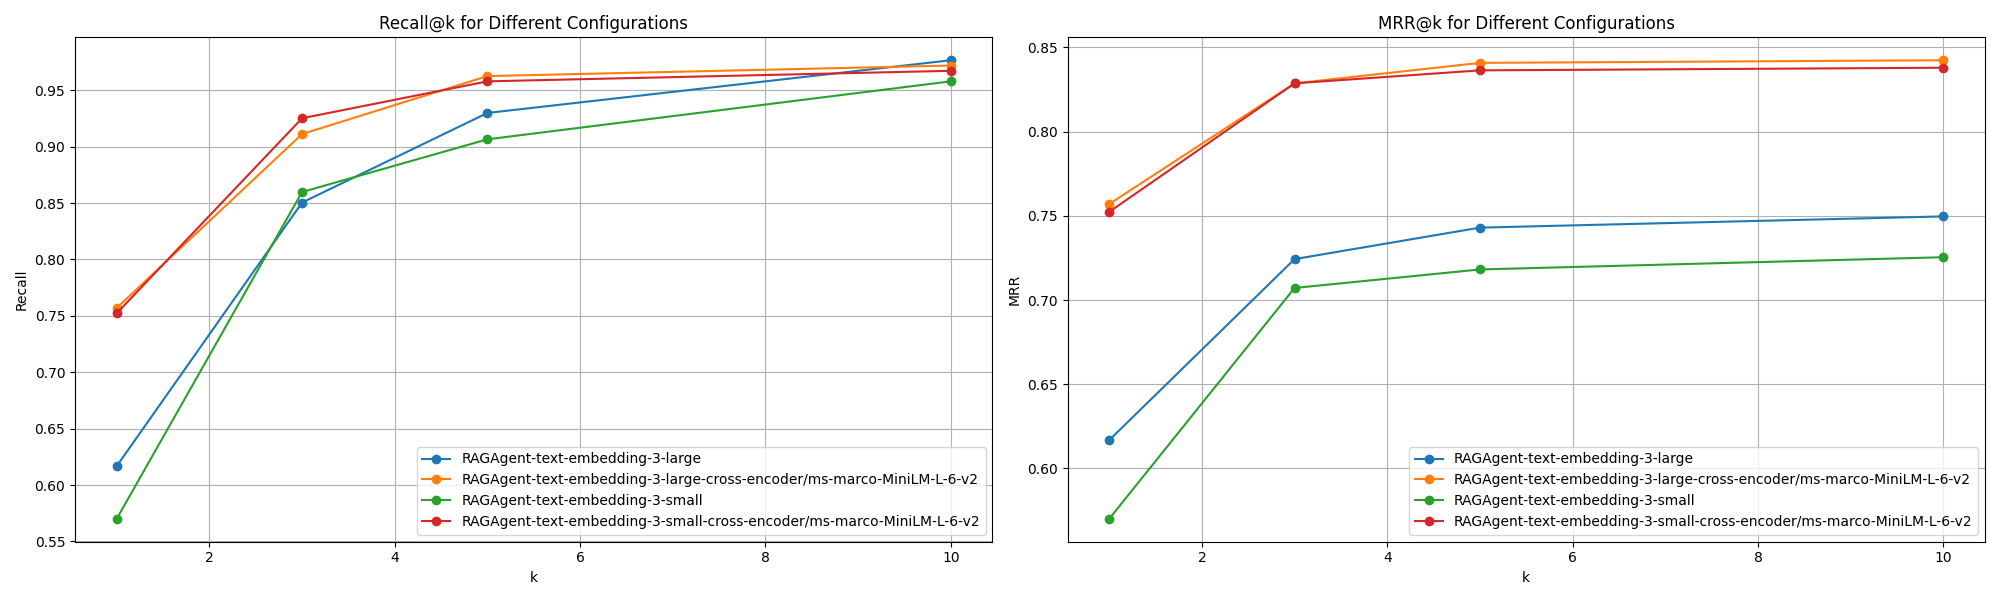

In [1]:
import IPython.display
img = open("../data/assets/configuration_comparison.png", "rb").read()
IPython.display.Image(data=img)

We find that adding a reranker - unsurprisingly - improves the performance of our RAG Agent. However, what's surprising, is that the large embedding model does not necessarily outperform the small embedding model in all metrics. This suggests that the small embedding model is more efficient and may be preferred in production settings. We only knew that by comparing the results systematically, rather than 'believing' that larger embedding models will increase performance. 

## 8. Conclusion

In this notebook, we've built and evaluated an agentic RAG system that can adaptively improve its retrieval performance through query reformulation. We've seen how this approach can lead to better results compared to traditional static RAG systems.

Key takeaways:

- Agentic RAG improves retrieval by iteratively refining queries
- Evaluation metrics like MRR and Precision@k help quantify improvements
- Visualization helps understand the performance of different configurations

To further improve your agentic RAG system, consider:

- Implementing more sophisticated retrieval strategies like hybrid search or multi-query retrieval
- Exploring different query reformulation techniques based on domain knowledge
- Integrating with a production system for real-world testing and refinement